在我之前的博客中我们介绍了文本的多分类的方法,我们还尝试了各种分类模型,比如朴素贝叶斯、逻辑回归、支持向量机和随机森林等并且都取得了非常不错的效果。今天我们使用深度学习中的LSTM（Long Short-Term Memory）长短期记忆网络，它是一种时间循环神经网络，适合于处理和预测时间序列中间隔和延迟相对较长的重要事件。
LSTM 已经在科技领域有了多种应用。基于 LSTM 的系统可以学习翻译语言、控制机器人、图像分析、文档摘要、语音识别图像识别、手写识别、控制聊天机器人、预测疾病、点击率和股票、合成音乐等等任务。今天我们用它来实现一下文本多分类，相信会取得较好的效果。

# 数据

我们的数据来自于互联网，你可以在这里下载,数据中包含了10 个类别（书籍、平板、手机、水果、洗发水、热水器、蒙牛、衣服、计算机、酒店），共 6 万多条评论数据 首先查看一下我们的数据，这些数据都是来自于电商网站的用户评价数据,我们想要把不同评价数据分到不同的分类中去,且每条数据只能对应10个类中的一个类。

数据下载地址:https://github.com/SophonPlus/ChineseNlpCorpus/blob/master/datasets/online_shopping_10_cats/intro.ipynb


In [1]:
#coding=utf-8
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import jieba as jb
import re

/home/zheming2009/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('./data/online_shopping_10_cats.csv')
df=df[['cat','review']]
print("数据总量: %d ." % len(df))
df.sample(10)

数据总量: 62774 .


,cat,review
21417,水果,一个字烂，两个字太烂，三个字非常烂，好差的苹果，第一次在京东上买到这么差的东西，商家太不负责...
24902,水果,第一买鲜货 结果很失望 有烂的 个头也很小
26050,水果,图片仅供参考～颜色并没有图片那么好看，苹果也很小，更不能常温储存，也不新鲜?
5680,平板,外观不错，只是用久了会不会慢？
24125,水果,这是放了多长时间的水果啊，长霉的长霉，烂的烂，流脓滴水，第一次京东买水果，还自营，就这品质？
10931,平板,不是很满意的一次购物 声音还特小 送的乐视会员 根本就兑换不了会员 一星都不想给
8806,平板,优点，很好用，屏幕大，带机时间长。缺点，只送了一个屏幕保护膜，套子都没送一个，还有我买的是3...
37303,蒙牛,个人比较喜欢蒙牛的新包装
4559,平板,感觉还可以，没有磨损，应该是新机，用一段时间再评论。
52941,酒店,所在地应该是徐汇比较好的地段，很幽静，旁边就是爱菊小学，出门往右走到路口有超市和水果店，好像...


In [3]:
print("在 cat 列中总共有 %d 个空值." % df['cat'].isnull().sum())
print("在 review 列中总共有 %d 个空值." % df['review'].isnull().sum())
df[df.isnull().values==True]
df = df[pd.notnull(df['review'])]


在 cat 列中总共有 0 个空值.
在 review 列中总共有 1 个空值.


In [4]:
d = {'cat':df['cat'].value_counts().index, 'count': df['cat'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)
df_cat

,cat,count
0,衣服,10000
1,水果,10000
2,洗发水,10000
3,平板,10000
4,酒店,10000
5,计算机,3992
6,书籍,3851
7,手机,2323
8,蒙牛,2033
9,热水器,574


Text(0.5,0,'类目')

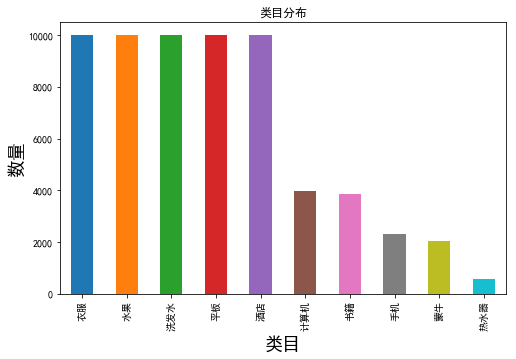

In [5]:
df_cat.plot(x='cat', y='count', kind='bar', legend=False,  figsize=(8, 5))
plt.title("类目分布")
plt.ylabel('数量', fontsize=18)
plt.xlabel('类目', fontsize=18)


# 数据预处理

 接下来我们要将cat类转换成id，这样便于以后的分类模型的训练。

In [6]:
df['cat_id'] = df['cat'].factorize()[0]
cat_id_df = df[['cat', 'cat_id']].drop_duplicates().sort_values('cat_id').reset_index(drop=True)
cat_to_id = dict(cat_id_df.values)
id_to_cat = dict(cat_id_df[['cat_id', 'cat']].values)
df.sample(10)


,cat,review,cat_id
5289,平板,质量一般，用电量太大了，不好用？,1
8917,平板,打电话时声音有噪音也没手电筒没耳机冲电也好慢,1
11888,平板,没有说的那么好，内存只有10G很卡,1
10101,平板,帮朋友给他们公司买的值班手机，手机电池有问题，因为收到货后刚刚充满电，很快就没电了，只能用两...,1
2415,书籍,"以上的评论太好,让我有购买的冲动,但我看过后,还没有<不生病的智慧>好呢",0
25648,水果,难得在京东上买一次生鲜，太失望了。火龙果一点不新鲜，一股霉味，以后再也不会买了,3
18268,水果,从京东自营水果区抢购了一瓶新鲜水果，苹果、丑柑、进口黄猕猴桃，家人都爱吃！京东价格便宜质量好...,3
7226,平板,手机很好 很大气 用起来运行速度也很快,1
62299,酒店,中午1点入住，到达房间门口却发现两张房卡均无法打开门锁，叫来楼层服务员打开后承诺马上把好的房...,9
21428,水果,垃圾，收到后隔天就全烂了，一个都没吃上,3


In [7]:
cat_id_df

,cat,cat_id
0,书籍,0
1,平板,1
2,手机,2
3,水果,3
4,洗发水,4
5,热水器,5
6,蒙牛,6
7,衣服,7
8,计算机,8
9,酒店,9


我们将cat转换成了Id(0到9),由于我们的评价内容都是中文,所以要对中文进行一些预处理工作,这包括删除文本中的标点符号,特殊符号,还要删除一些无意义的常用词(stopword),因为这些词和符号对系统分析预测文本的内容没有任何帮助,反而会增加计算的复杂度和增加系统开销,所有在使用这些文本数据之前必须要将它们清理干净。

In [8]:
#定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line
 
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords  

#加载停用词
stopwords = stopwordslist("./data/chineseStopWords.txt")

中文停用词包含了很多日常使用频率很高的常用词,如 吧，吗，呢，啥等一些感叹词等,这些高频常用词无法反应出文本的主要意思,所以要被过滤掉。

In [9]:
#删除除字母,数字，汉字以外的所有符号
df['clean_review'] = df['review'].apply(remove_punctuation)
df.sample(10)

,cat,review,cat_id,clean_review
22088,水果,买回去几个都是坏的，当时没有看收货的时候应该装的时候就已经发霉了,3,买回去几个都是坏的当时没有看收货的时候应该装的时候就已经发霉了
62764,酒店,非常一般的酒店，房里设施很旧，房间送餐竟然要加多50%的送餐费。总之找不到好的方面来说，有其...,9,非常一般的酒店房里设施很旧房间送餐竟然要加多50的送餐费总之找不到好的方面来说有其他选择就不要去了
61015,酒店,位置不错，赶飞机很方便，有机场至宾馆互通大吧，司机根不错，赞一个，就是反复飞机飞过声音很大…,9,位置不错赶飞机很方便有机场至宾馆互通大吧司机根不错赞一个就是反复飞机飞过声音很大
28147,洗发水,物流速度很给力，两大瓶三小瓶，用起来也很不错，,4,物流速度很给力两大瓶三小瓶用起来也很不错
47465,衣服,商品是拼接品。,7,商品是拼接品
32590,洗发水,明明下单了两套礼盒，结果今天只送货送到了一套？！是快递人员的疏忽还是厂家的失误？！还是说这就...,4,明明下单了两套礼盒结果今天只送货送到了一套是快递人员的疏忽还是厂家的失误还是说这就是趁双十一...
10618,平板,手机充满状态下，待机无故发热耗电，几小时没电关机了，本来是当备用机的如今待机都不行服了！问客...,1,手机充满状态下待机无故发热耗电几小时没电关机了本来是当备用机的如今待机都不行服了问客服说后台...
53540,酒店,房间感觉很上海化，结构紧凑，服务态度尚可，大厅也不错，是个标准的四星酒店。只是周边环境不是特...,9,房间感觉很上海化结构紧凑服务态度尚可大厅也不错是个标准的四星酒店只是周边环境不是特别的优雅如...
5409,平板,买来降价了。。。。买给老人听戏用的。老人很满意。就是内存小。价钱在这了。,1,买来降价了买给老人听戏用的老人很满意就是内存小价钱在这了
12843,平板,不值这个价钱，是别人退货的产品，很明显是拆封过的，很不爽的一次购物,1,不值这个价钱是别人退货的产品很明显是拆封过的很不爽的一次购物


我们过滤掉了review中的标点符号和一些特殊符号，并生成了一个新的字段 clean_review。接下来我们要在clean_review的基础上进行分词,把每个评论内容分成由空格隔开的一个一个单独的词语。

In [10]:
#分词，并过滤停用词
df['cut_review'] = df['clean_review'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
df.head()

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.876 seconds.
Prefix dict has been built succesfully.


,cat,review,cat_id,clean_review,cut_review
0,书籍,﻿做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持...,0,做父母一定要有刘墉这样的心态不断地学习不断地进步不断地给自己补充新鲜血液让自己保持一颗年轻的...,做 父母 一定 刘墉 心态 不断 学习 不断 进步 不断 补充 新鲜血液 保持 一颗 年轻 ...
1,书籍,作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...,0,作者真有英国人严谨的风格提出观点进行论述论证尽管本人对物理学了解不深但是仍然能感受到真理的火...,作者 真有 英国人 严谨 风格 提出 观点 进行 论述 论证 物理学 了解 不深 仍然 感受...
2,书籍,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点。为什么荷兰曾经县有欧洲最高的生产...,0,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点为什么荷兰曾经县有欧洲最高的生产率...,作者 长篇大论 借用 详细 报告 数据处理 工作 计算结果 支持 其新 观点 荷兰 曾经 县...
3,书籍,作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...,0,作者在战几时之前用了拥抱令人叫绝日本如果没有战败就有会有美军的占领没胡官僚主义的延续没有战后...,作者 战 之前 拥抱 令人 叫绝 日本 没有 战败 会 美军 占领 没胡 官僚主义 延续 没...
4,书籍,作者在少年时即喜阅读，能看出他精读了无数经典，因而他有一个庞大的内心世界。他的作品最难能可贵...,0,作者在少年时即喜阅读能看出他精读了无数经典因而他有一个庞大的内心世界他的作品最难能可贵的有两...,作者 少年 时即 喜 阅读 看出 精读 无数 经典 一个 庞大 内心世界 作品 难能可贵 两...


# LSTM建模 

数据预处理完成以后，接下来我们要开始进行LSTM的建模工作：

* 我们要将cut_review数据进行向量化处理,我们要将每条cut_review转换成一个整数序列的向量
* 设置最频繁使用的50000个词
* 设置每条 cut_review最大的词语数为250个(超过的将会被截去,不足的将会被补0)

In [11]:
# 设置最频繁使用的50000个词(在texts_to_matrix是会取前MAX_NB_WORDS,会取前MAX_NB_WORDS列)
MAX_NB_WORDS = 50000
# 每条cut_review最大的长度
MAX_SEQUENCE_LENGTH = 250
# 设置Embeddingceng层的维度
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['cut_review'].values)
word_index = tokenizer.word_index
print('共有 %s 个不相同的词语.' % len(word_index))

共有 70364 个不相同的词语.


训练和测试的数据集都准备好以后,接下来我们要定义一个LSTM的序列模型:  

* 模型的第一次是嵌入层(Embedding)，它使用长度为100的向量来表示每一个词语
* SpatialDropout1D层在训练中每次更新时， 将输入单元的按比率随机设置为 0， 这有助于防止过拟合
* LSTM层包含100个记忆单元
* 输出层为包含10个分类的全连接层
* 由于是多分类，所以激活函数设置为'softmax'
* 由于是多分类, 所以损失函数为分类交叉熵categorical_crossentropy

In [14]:
X = tokenizer.texts_to_sequences(df['cut_review'].values)
#填充X,让X的各个列的长度统一
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

#多类标签的onehot展开
Y = pd.get_dummies(df['cat_id']).values

print(X.shape)
print(Y.shape)


(62773, 250)
(62773, 10)


In [16]:
#拆分训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(56495, 250) (56495, 10)
(6278, 250) (6278, 10)


In [17]:
#定义模型
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 5,081,410
Trainable params: 5,081,410
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 50845 samples, validate on 5650 samples
Epoch 1/5
50845/50845 [==============================] - 444s 9ms/step - loss: 0.7750 - acc: 0.7390 - val_loss: 0.3645 - val_acc: 0.8791
Epoch 2/5
50845/50845 [==============================] - 440s 9ms/step - loss: 0.2987 - acc: 0.9020 - val_loss: 0.3266 - val_acc: 0.8899
Epoch 3/5
50845/50845 [==============================] - 441s 9ms/step - loss: 0.2120 - acc: 0.9287 - val_loss: 0.3237 - val_acc: 0.8931
Epoch 4/5
50845/50845 [==============================] - 440s 9ms/step - loss: 0.1692 - acc: 0.9429 - val_loss: 0.3600 - val_acc: 0.8892
Epoch 5/5
50845/50845 [==============================] - 441s 9ms/step - loss: 0.1473 - acc: 0.9500 - val_loss: 0.3665 - val_acc: 0.8865


In [19]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

6278/6278 [==============================] - 13s 2ms/step
Test set
  Loss: 0.353
  Accuracy: 0.890


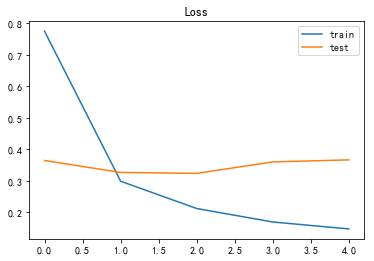

In [20]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

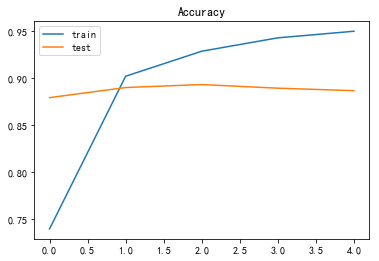

In [21]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

# LSTM模型的评估 

接下来我们通过画混淆矩阵和求F1分数来评估我们模型的表现

In [22]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis = 1)
Y_test = Y_test.argmax(axis = 1)

Text(0.5,51.2344,'预测结果')

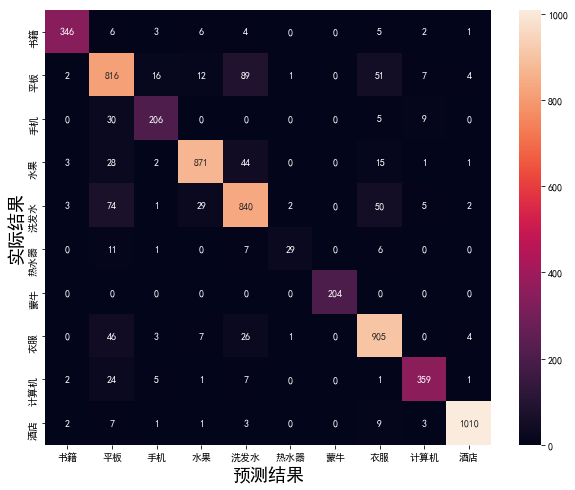

In [23]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
#生成混淆矩阵
conf_mat = confusion_matrix(Y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=cat_id_df.cat.values, yticklabels=cat_id_df.cat.values)
plt.ylabel('实际结果',fontsize=18)
plt.xlabel('预测结果',fontsize=18)



In [27]:
from  sklearn.metrics import classification_report
 
print('accuracy %s' % accuracy_score(y_pred, Y_test))
print(classification_report(Y_test, y_pred,target_names=cat_id_df['cat'].values))


accuracy 0.8897738133163428
             precision    recall  f1-score   support

         书籍       0.97      0.93      0.95       373
         平板       0.78      0.82      0.80       998
         手机       0.87      0.82      0.84       250
         水果       0.94      0.90      0.92       965
        洗发水       0.82      0.83      0.83      1006
        热水器       0.88      0.54      0.67        54
         蒙牛       1.00      1.00      1.00       204
         衣服       0.86      0.91      0.89       992
        计算机       0.93      0.90      0.91       400
         酒店       0.99      0.97      0.98      1036

avg / total       0.89      0.89      0.89      6278



# 自定义预测

首先我们定义一个预测函数:通过输入一段评语,来预测它的类目

In [81]:
def predict(text):
    txt = remove_punctuation(text)
    txt = [" ".join([w for w in list(jb.cut(txt)) if w not in stopwords])]
    seq = tokenizer.texts_to_sequences(txt)
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    cat_id= pred.argmax(axis=1)[0]
    return cat_id_df[cat_id_df.cat_id==cat_id]['cat'].values[0]
      

In [84]:
predict('苹果好吃又不贵，已经买了很多次了')

'水果'

In [83]:
predict('收到产品已经半个多月了，一开始用着不太好用，慢慢的就好使了，可能是习惯问题吧，主要是屏的分辨率真的不错。')

'平板'

In [86]:
predict('可能中外文化理解差异，可能与小孩子太有代沟，不觉得怎么样，还是比较喜欢水墨画一点风格的漫画书，但愿我女儿长大一点能喜欢（22个月中）')

'书籍'

In [87]:
predict('假的，不好用，头皮痒的要命。。。')

'洗发水'

In [89]:
predict('这是第三次点评，纯粹是为了拿积分。没什么可以多说了，服务不错。')

'酒店'

In [90]:
#自定义review
predict('房间挺大，就是价格贵了点')

'酒店'

In [91]:
#自定义review
predict('酸的要死，下次不买了')

'水果'

In [92]:
#自定义review
predict('酸的要死，下次不买了')

'水果'

In [93]:
#自定义review
predict('用了几天就好卡，上当了，退款')

'平板'

In [95]:
#自定义review
predict('用了几次发现头好痒，感觉过敏了')

'洗发水'

In [98]:
predict('手写识别还可以')

'手机'

In [99]:
predict('T恤很好看，就是短了点')

'衣服'